## Análisis exploratorio
El objetivo de este notebook es comenzar a buscar relaciones entre las variables y el target con el fin de tener una idea acerca de posibles features para entrenar al modelo. También se le hará un tratamiento a los outliers y en caso de que sea necesario se generarán nuevas variables. Dado que en el notebook anterior ya se hicieron algunas visualizaciones, en este no volveran a hacer.

### Import de los paquetes

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore

# Ignorar todas las advertencias
warnings.filterwarnings("ignore")


%matplotlib inline

### Carga de datos

In [2]:
df = pd.read_csv("../data/raw/dataTestDS.csv", index_col=0)
df.shape

(3000, 11)

### Procesamiento

#### Creación del target

In [3]:
# Dado el notebook anterior definimos una variable que indique si la factura esta o no paga
df["facturaMorosa"] = np.where(df["mora"] > 0, 1, 0)

#### Tipo de datos

In [4]:
# Dado que estos campos tienen valores altos los casteamos para facilidad de lectura
df["montoFactura"] = df["montoFactura"].astype(int)
df["issuerInvoicesAmount"] = df["issuerInvoicesAmount"].astype(int)

### Análisis exploratorio

#### Estado de la factura
Analizamos ante que clase de problema nos encontramos: balanceado o desbalanceado.

In [5]:
# Agrupamos por tipo y contabilizamos
df_facturas_estado = df.groupby("facturaMorosa").size().reset_index(name="nro_facturas")
df_facturas_estado["porcentaje"] = df_facturas_estado["nro_facturas"].apply(
    lambda x: x / df.shape[0] * 100
)

# Le damos nombre a las categorias
df_facturas_estado["facturaMorosa"] = df_facturas_estado["facturaMorosa"].map(
    {0: "Paga", 1: "Impaga"}
)

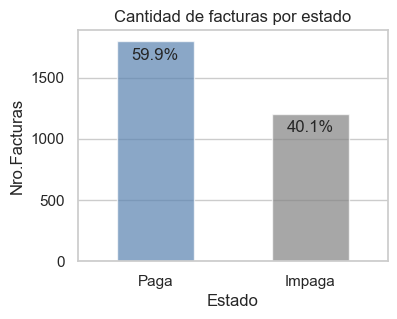

In [6]:
# Se configura el estilo de Seaborn
sns.set(style="whitegrid")

# Se crea el gráfico de barras
plt.figure(figsize=(4, 3))
ax = sns.barplot(
    x="facturaMorosa",
    y="nro_facturas",
    data=df_facturas_estado,
    alpha=0.7,
    palette=["#4A81BF", "#828282"],
    width=0.5,
)

# Se agrega etiquetas y título
plt.xlabel("Estado")
plt.ylabel("Nro.Facturas")
plt.title("Cantidad de facturas por estado")

# Se agregan anotaciones
for p, value in zip(ax.patches, df_facturas_estado["porcentaje"]):
    ax.annotate(
        f"{value:.1f}%",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, -10),
        textcoords="offset points",
    )


# Se muestra el gráfico
plt.show()

**Notas:**

Observando los valores concluimos que estamos ante un problema balanceado.

#### Cantidad de facturas por parte
Es importante este punto dado que nos permite ver la cantidad de facturas por cada parte. Si queremos calculamos como un estado de morosidad de cada uno, necesitamos facturas previas y estos nos permite ver eso.

##### Business

In [7]:
# Agrupamos por emisor y contabilizamos
df_business_nro_facturas = (
    df.groupby("businessId").size().reset_index(name="nro_facturas")
)

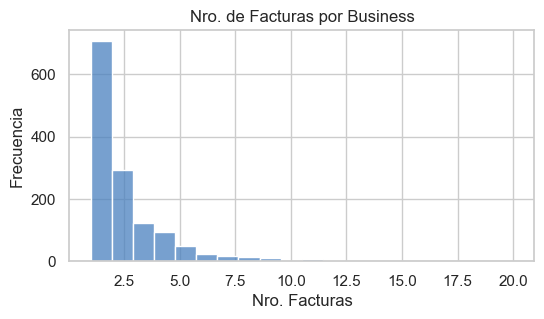

In [8]:
# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear el histograma
plt.figure(figsize=(6, 3))
sns.histplot(
    df_business_nro_facturas, x="nro_facturas", bins=20, color="#4A81BF", kde=False
)

# Agregar etiquetas y título
plt.xlabel("Nro. Facturas")
plt.ylabel("Frecuencia")
plt.title("Nro. de Facturas por Business")

# Mostrar el histograma
plt.show()

**Notas:**

Se podría decir que la mayoría de los emisores cuentan con pocas facturas emitidas.

##### Payer

In [9]:
# Agrupamos por emisor y contabilizamos
df_payer_nro_facturas = df.groupby("payerId").size().reset_index(name="nro_facturas")

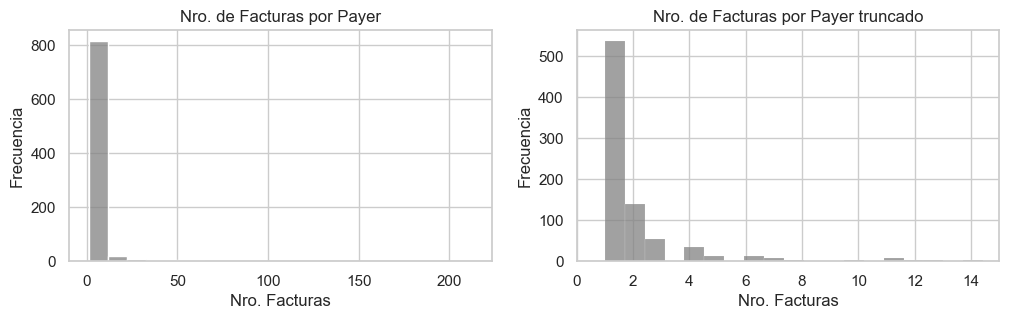

In [10]:
# Se configura el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), sharex=False)

# Se creo el histograma
sns.histplot(
    df_payer_nro_facturas,
    x="nro_facturas",
    bins=20,
    color="#828282",
    kde=False,
    ax=axes[0],
)

# Se agrega etiquetas y título
axes[0].set_xlabel("Nro. Facturas")
axes[0].set_ylabel("Frecuencia")
axes[0].set_title("Nro. de Facturas por Payer")


# Generamos el mismo grafico pero truncado
# Se creo el histograma con Seaborn
sns.histplot(
    df_payer_nro_facturas,
    x="nro_facturas",
    bins=300,
    color="#828282",
    kde=False,
    ax=axes[1],
)

# Se agrega etiquetas y título
axes[1].set_xlabel("Nro. Facturas")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Nro. de Facturas por Payer truncado")

axes[1].set_xlim([0, 15])

# Se muestra el histograma
plt.show()

**Notas:**

Se observa que existe un payer con un número excesivo de facturas. Esto ya se observó en el reporte del primer notebook. Para poder observar los datos de forma correcta truncamos el eje, esto se observa en el segundo gráfico. Se observa nuevamente que la mayoría de los payers tienen pocas facturas.

**Conclusiones:**

En condiciones normal podría decirse que estos generar features históricas se encuentra ante el incoveniente de la poca historia que tenemos de cada una de las partes. Sin embargo, el historial de cada parte es importantisimo por lo que creo necesario a pesar de la poca cantidad de datos, que hay que incluirlos.

#### Correlación entre las variables

El objetivo de este tipo de diagramas son los siguientes:
- Identificar variables relevantes.
- Detectar multicolinealidad
- Dar evidencia a algunos supuestos de negocios

In [11]:
# Calculamos la matriz de correlación
correlation_matrix = df.corr()

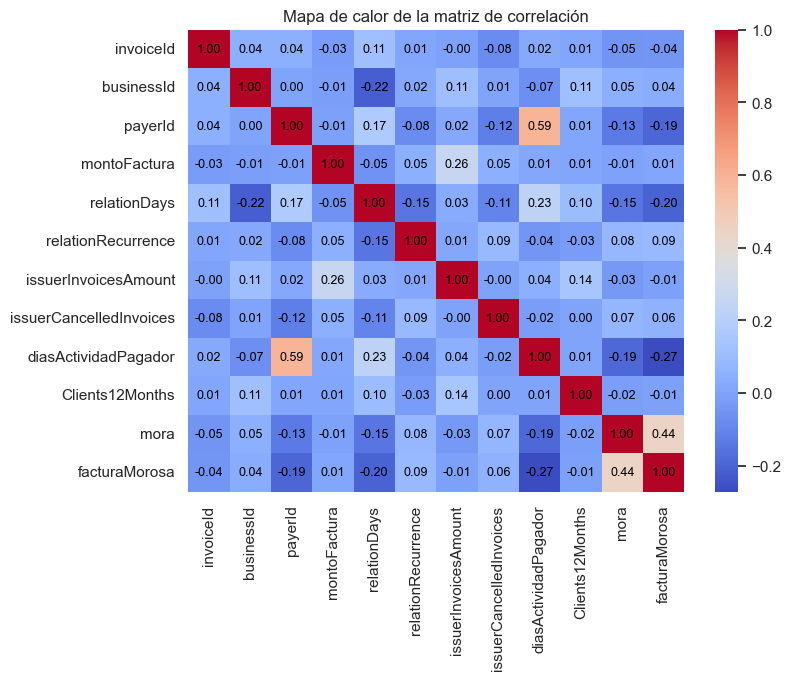

In [12]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos el mapa de calor
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")

# Agregamos los valores dentro del mapa de calor
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = f"{correlation_matrix.iloc[i, j]:.2f}"
        heatmap.text(
            j + 0.5, i + 0.5, text, ha="center", va="center", color="black", size="9"
        )

# Ajustamos el diseño y mostramos el mapa de calor
plt.title("Mapa de calor de la matriz de correlación")
plt.show()

**Notas:**

Se bien respecto al target no hay valores significativos que nos pueda dar seguridad de los "mejores variables" podemos hacer algunas observaciones:

- Da la sensación que existe algun tipo de relación entre la antiguedad del pagador y los dias de morosidad. Una presunción podría ser que los pagadores antiguos son más confiables que los nuevos. Esto tambíen se podría decir respecto a la antiguedad de las relaciones entre partes.
- Otra conjetura podría ser en relación a la variable relationRecurrence. Podríamos suponer que cuanto el pagador no cumple con su deber, la iteracción entre las partes es menor.
- Inicialmente podría pensarse que las facturas con mayores montos son en teoría las que más mora tienen pero al parecer no hay una relación fuerte que nos permita confiar en esta teoría.

#### Monto Factura

##### Boxplot
La idea es detectar outliers dado que ya observamos anteriormente las estadística descriptiva de cada variable.

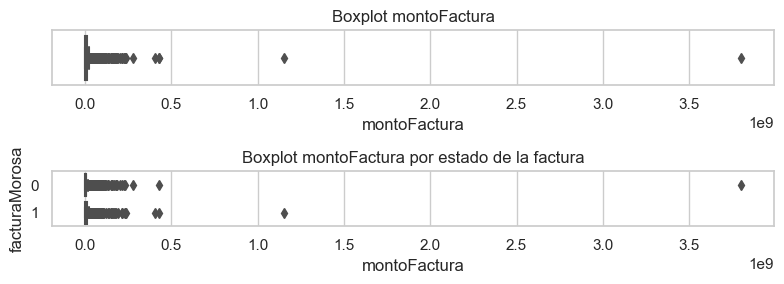

In [13]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 3), sharex=False)

# Boxplot 1
sns.boxplot(x="montoFactura", data=df, color="#4A81BF", ax=axes[0])
axes[0].set_title("Boxplot montoFactura")

# Boxplot 2
sns.boxplot(
    y="facturaMorosa",
    x="montoFactura",
    data=df,
    orient="h",
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Boxplot montoFactura por estado de la factura")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los boxplots
plt.show()

**Nota:**

Los valores extremos son muy grandes, lo que hace imposible observar estos gráficos. A esta variables la consideramos con outliers.

##### Relación con la variable mora

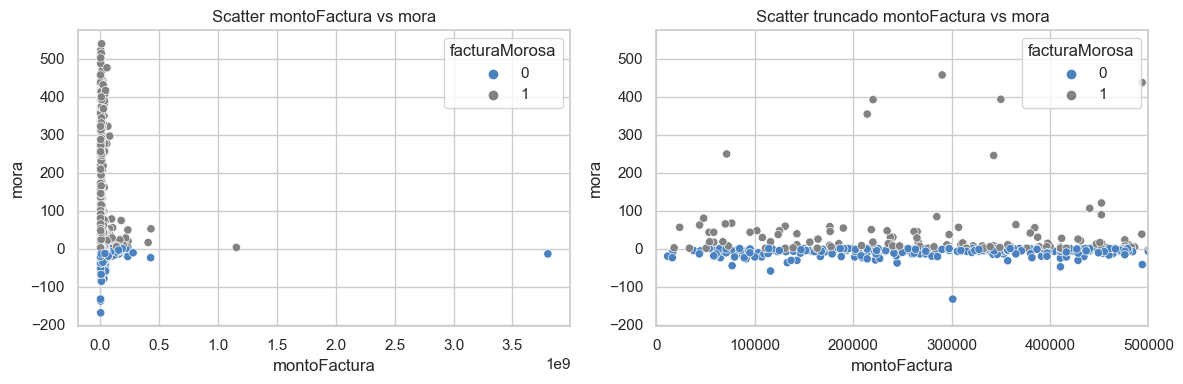

In [14]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot 1
sns.scatterplot(
    x="montoFactura",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
axes[0].set_title("Scatter montoFactura vs mora")

# Scatter plot 2
sns.scatterplot(
    x="montoFactura",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Scatter truncado montoFactura vs mora")

# Ajustamos el diseño
axes[1].set_xlim([0, 500000])
plt.tight_layout()

# Mostramos los scatter plots
plt.show()

##### Relación con la variable factMorosa

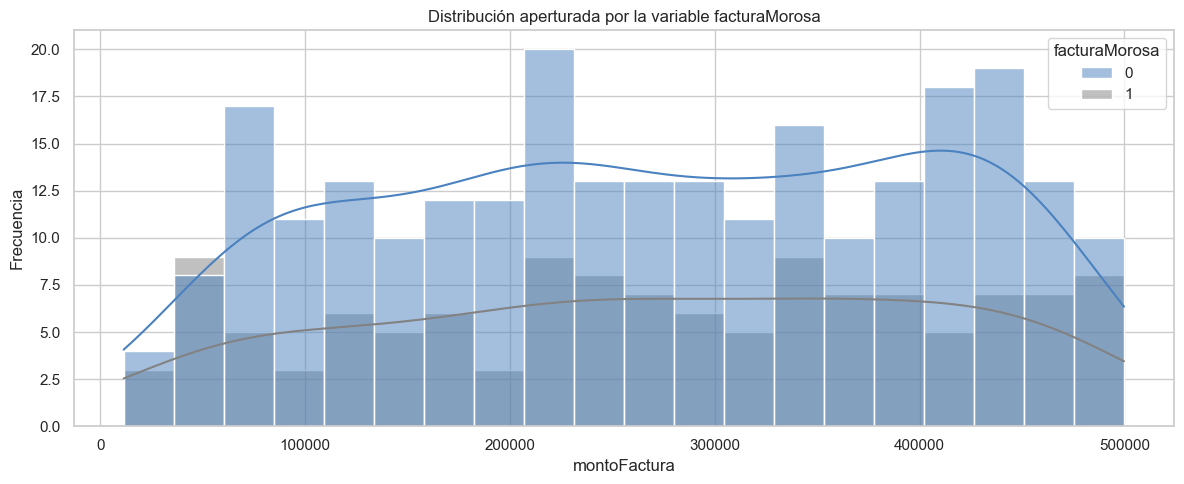

In [15]:
# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear el histograma
plt.figure(figsize=(12, 5))

sns.histplot(
    df.loc[df["montoFactura"] < 500000],
    x="montoFactura",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregar etiquetas y título
plt.xlabel("montoFactura")
plt.ylabel("Frecuencia")
plt.title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostrar el histograma
plt.show()

#### Relation Days

##### Boxplot
La idea es detectar outliers dado que ya observamos anteriormente las estadística descriptiva de cada variable.

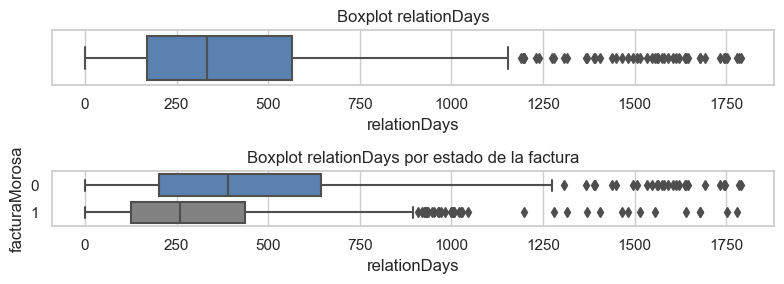

In [16]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 3), sharex=False)

# Boxplot 1
sns.boxplot(x="relationDays", data=df, color="#4A81BF", ax=axes[0])
axes[0].set_title("Boxplot relationDays")

# Boxplot 2
sns.boxplot(
    y="facturaMorosa",
    x="relationDays",
    data=df,
    orient="h",
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Boxplot relationDays por estado de la factura")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los boxplots
plt.show()

**Nota:**

Existe la posibilidad de que haya outliers, pero creo que son valores que dentro del negocio se pueden dar dado que pueden existir relaciones de largo plazo entre ambas partes.

##### Relación con la variable mora

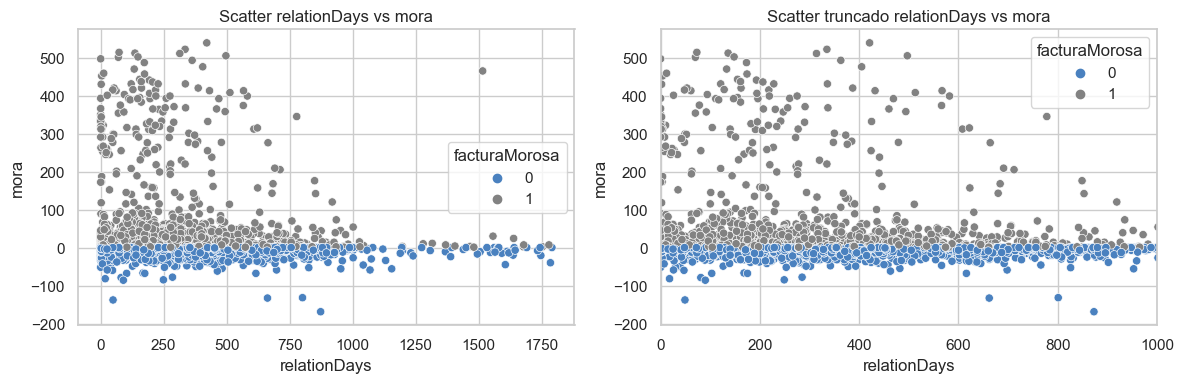

In [17]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot 1
sns.scatterplot(
    x="relationDays",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
axes[0].set_title("Scatter relationDays vs mora")

# Scatter plot 2
sns.scatterplot(
    x="relationDays",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Scatter truncado relationDays vs mora")

# Ajustamos el diseño
axes[1].set_xlim([0, 1000])
plt.tight_layout()

# Mostramos los scatter plots
plt.show()

##### Relación con la variable factMorosa

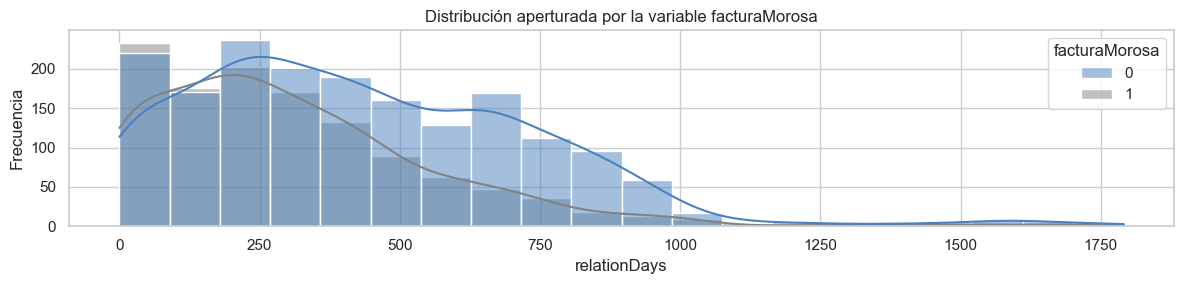

In [18]:
# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear el histograma
plt.figure(figsize=(12, 3))

sns.histplot(
    df,
    x="relationDays",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregar etiquetas y título
plt.xlabel("relationDays")
plt.ylabel("Frecuencia")
plt.title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostrar el histograma
plt.show()

**Nota:**

Se puede ver lo que mencionamos anteriormente, al parecer los clientes más nuevos de determinados emisores suelen ser los que más morosidad suelen tener.

#### Relation Recurrence

##### Boxplot
La idea es detectar outliers dado que ya observamos anteriormente las estadística descriptiva de cada variable.

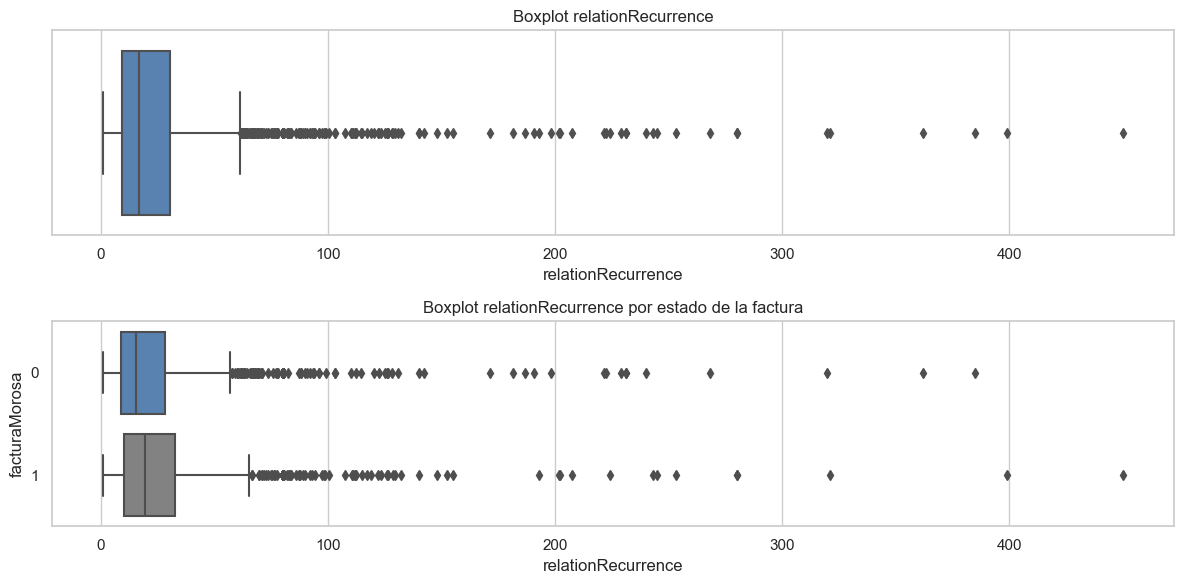

In [19]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=False)

# Boxplot 1
sns.boxplot(x="relationRecurrence", data=df, color="#4A81BF", ax=axes[0])
axes[0].set_title("Boxplot relationRecurrence")

# Boxplot 2
sns.boxplot(
    y="facturaMorosa",
    x="relationRecurrence",
    data=df,
    orient="h",
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Boxplot relationRecurrence por estado de la factura")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los boxplots
plt.show()

**Nota:**

Existen outliers al parecer pero si las partes son empresas grandes por ejemplo, podría darse el caso de que entre ambas exista un vínculo fuerte y tenga miles de transacciones por día.

##### Relación con la variable mora

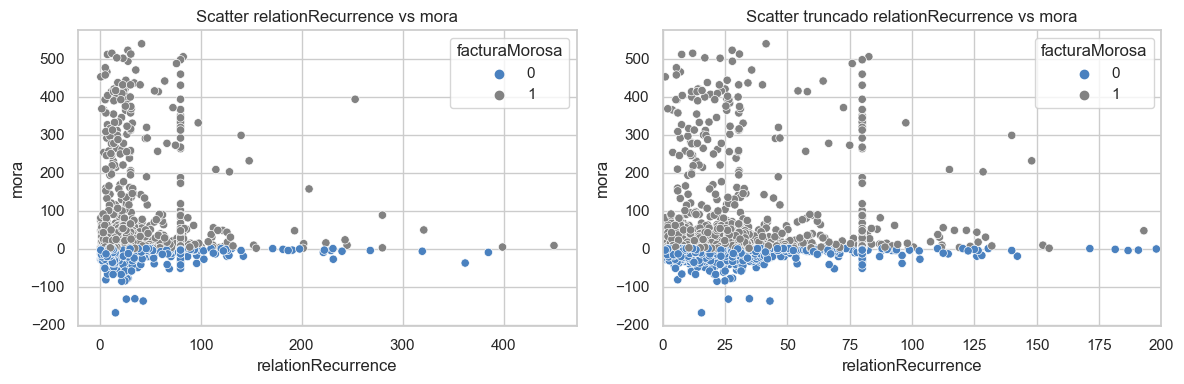

In [20]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot 1
sns.scatterplot(
    x="relationRecurrence",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
axes[0].set_title("Scatter relationRecurrence vs mora")

# Scatter plot 2
sns.scatterplot(
    x="relationRecurrence",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Scatter truncado relationRecurrence vs mora")

# Ajustamos el diseño
axes[1].set_xlim([0, 200])
plt.tight_layout()

# Mostramos los scatter plots
plt.show()

##### Relación con la variable factMorosa

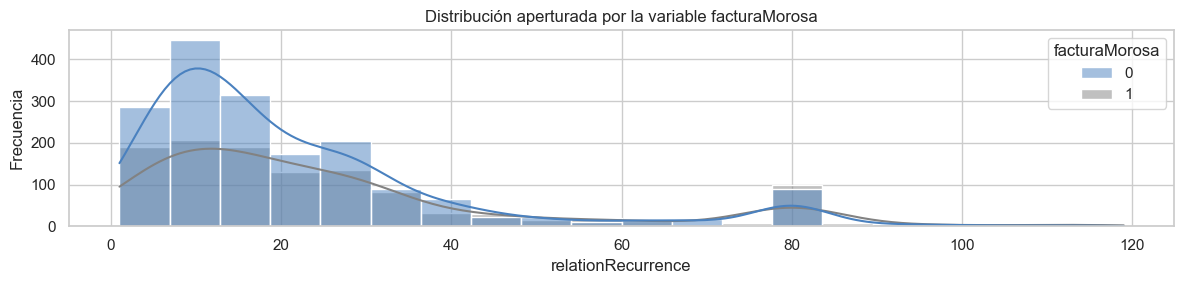

In [21]:
# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear el histograma
plt.figure(figsize=(12, 3))

sns.histplot(
    df.loc[df["relationRecurrence"] < 120],
    x="relationRecurrence",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregar etiquetas y título
plt.xlabel("relationRecurrence")
plt.ylabel("Frecuencia")
plt.title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostrar el histograma
plt.show()

**Notas:**
- Se observa sobre todo en el scatter lo que mencionamos anteriormente que existen muchos casos donde ambas partes tienen pocas iteracciones que la morisidad parece ser mayor.
- Volvemos a observar nuevamente los casos cuyo valor es "80".

#### Issuer Invoices Amount

##### Boxplot
La idea es detectar outliers dado que ya observamos anteriormente las estadística descriptiva de cada variable.

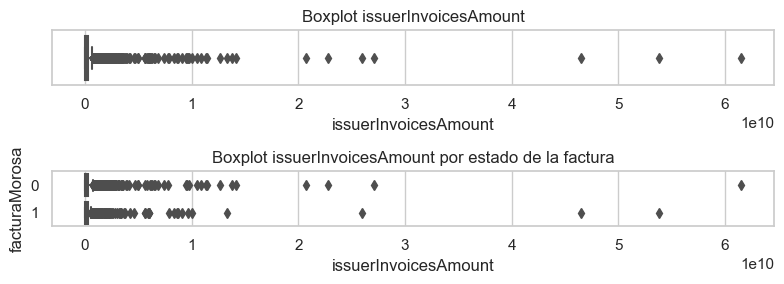

In [22]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 3), sharex=False)

# Boxplot 1
sns.boxplot(x="issuerInvoicesAmount", data=df, color="#4A81BF", ax=axes[0])
axes[0].set_title("Boxplot issuerInvoicesAmount")

# Boxplot 2
sns.boxplot(
    y="facturaMorosa",
    x="issuerInvoicesAmount",
    data=df,
    orient="h",
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Boxplot issuerInvoicesAmount por estado de la factura")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los boxplots
plt.show()

**Nota:**

Podríamos concluir en lo mismo que para la variable montoFactura.

##### Relación con la variable mora

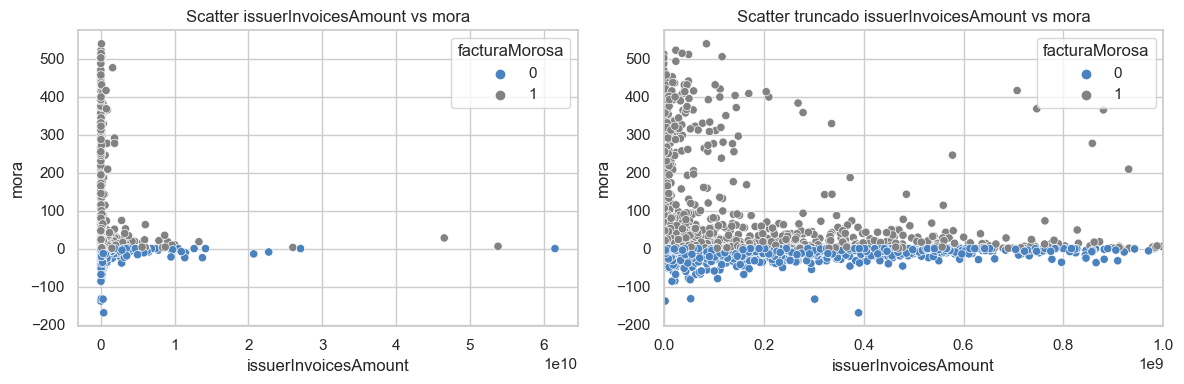

In [23]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot 1
sns.scatterplot(
    x="issuerInvoicesAmount",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
axes[0].set_title("Scatter issuerInvoicesAmount vs mora")

# Scatter plot 2
sns.scatterplot(
    x="issuerInvoicesAmount",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Scatter truncado issuerInvoicesAmount vs mora")

# Ajustamos el diseño
axes[1].set_xlim([0, 1e9])
plt.tight_layout()

# Mostramos los scatter plots
plt.show()

##### Relación con la variable factMorosa

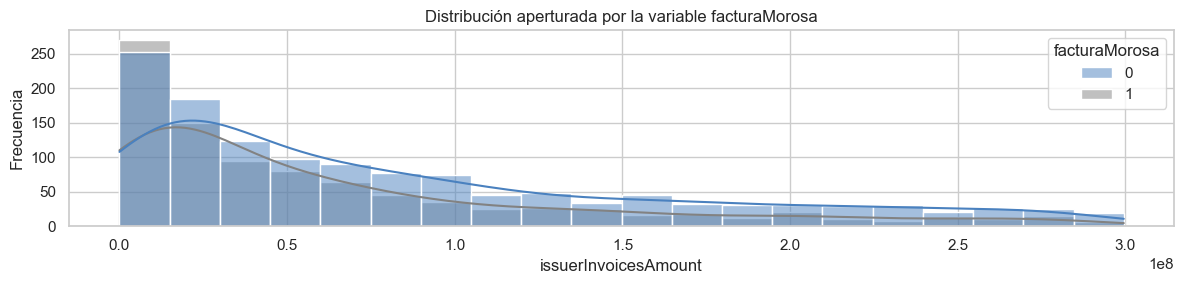

In [24]:
# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear el histograma
plt.figure(figsize=(12, 3))

sns.histplot(
    df.loc[df["issuerInvoicesAmount"] < 3e8],
    x="issuerInvoicesAmount",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregar etiquetas y título
plt.xlabel("issuerInvoicesAmount")
plt.ylabel("Frecuencia")
plt.title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostrar el histograma
plt.show()

**Notas:**
En principio es dificil mencionar algo destacable sobre lo observado. Habría que probar algunas estrategias de feature seleccion para ver si podes utilizar o no esta variable en el modelo.

#### Issuer Cancelled Invoices

##### Boxplot
La idea es detectar outliers dado que ya observamos anteriormente las estadística descriptiva de cada variable.

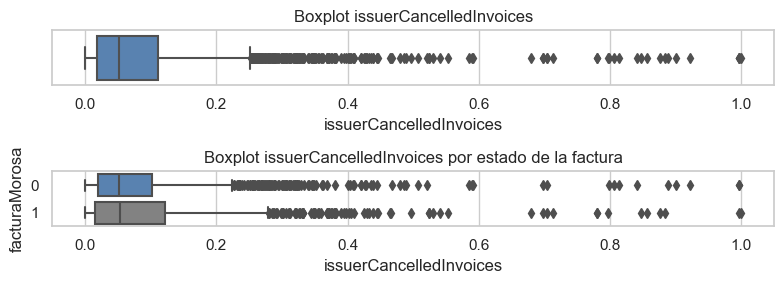

In [25]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 3), sharex=False)

# Boxplot 1
sns.boxplot(x="issuerCancelledInvoices", data=df, color="#4A81BF", ax=axes[0])
axes[0].set_title("Boxplot issuerCancelledInvoices")

# Boxplot 2
sns.boxplot(
    y="facturaMorosa",
    x="issuerCancelledInvoices",
    data=df,
    orient="h",
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Boxplot issuerCancelledInvoices por estado de la factura")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los boxplots
plt.show()

**Nota:**

No se observa nada destacable. Dado que es un rate, todos los valores se podrían considerar como válidos.

##### Relación con la variable mora

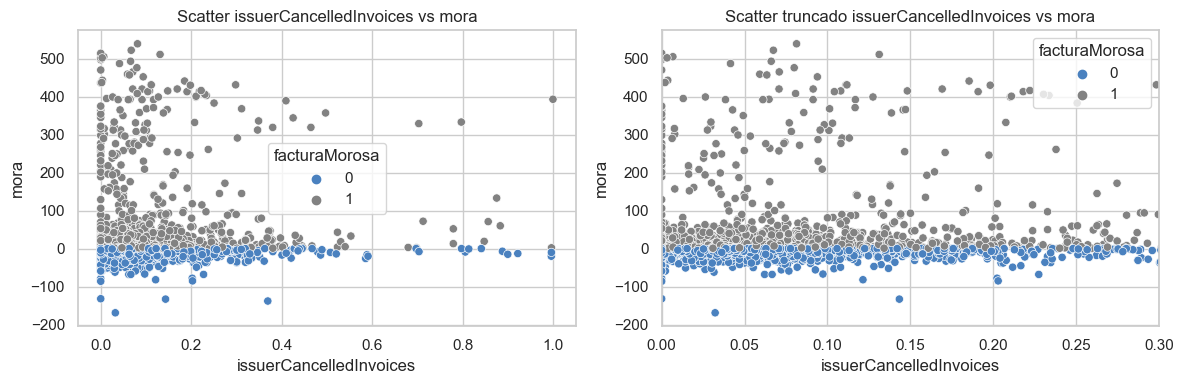

In [26]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot 1
sns.scatterplot(
    x="issuerCancelledInvoices",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
axes[0].set_title("Scatter issuerCancelledInvoices vs mora")

# Scatter plot 2
sns.scatterplot(
    x="issuerCancelledInvoices",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Scatter truncado issuerCancelledInvoices vs mora")

# Ajustamos el diseño
axes[1].set_xlim([0, 0.3])
plt.tight_layout()

# Mostramos los scatter plots
plt.show()

##### Relación con la variable factMorosa

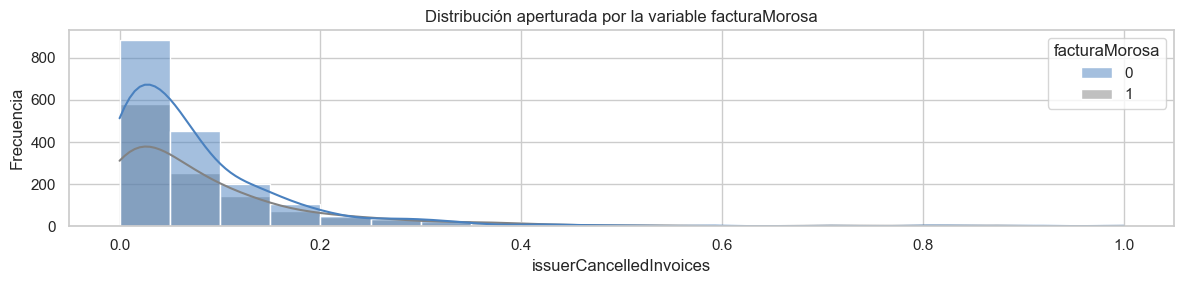

In [27]:
# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear el histograma
plt.figure(figsize=(12, 3))

sns.histplot(
    df,
    x="issuerCancelledInvoices",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregar etiquetas y título
plt.xlabel("issuerCancelledInvoices")
plt.ylabel("Frecuencia")
plt.title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostrar el histograma
plt.show()

**Notas:**
Misma conclusión que en el punto anterior, es dificil notar algo que destaque mucho como para mencionar algo muy especial. 

#### Dias Actividad Pagador

##### Boxplot
La idea es detectar outliers dado que ya observamos anteriormente las estadística descriptiva de cada variable.

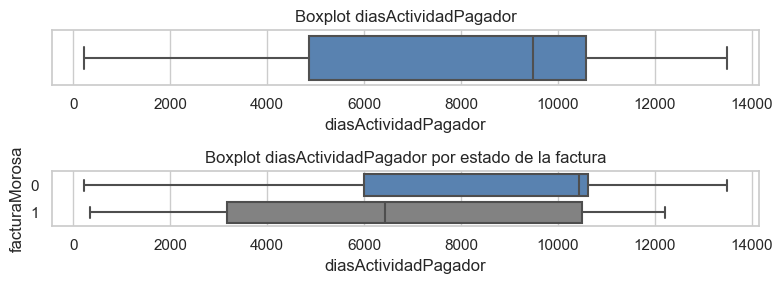

In [28]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 3), sharex=False)

# Boxplot 1
sns.boxplot(x="diasActividadPagador", data=df, color="#4A81BF", ax=axes[0])
axes[0].set_title("Boxplot diasActividadPagador")

# Boxplot 2
sns.boxplot(
    y="facturaMorosa",
    x="diasActividadPagador",
    data=df,
    orient="h",
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Boxplot diasActividadPagador por estado de la factura")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los boxplots
plt.show()

##### Relación con la variable mora

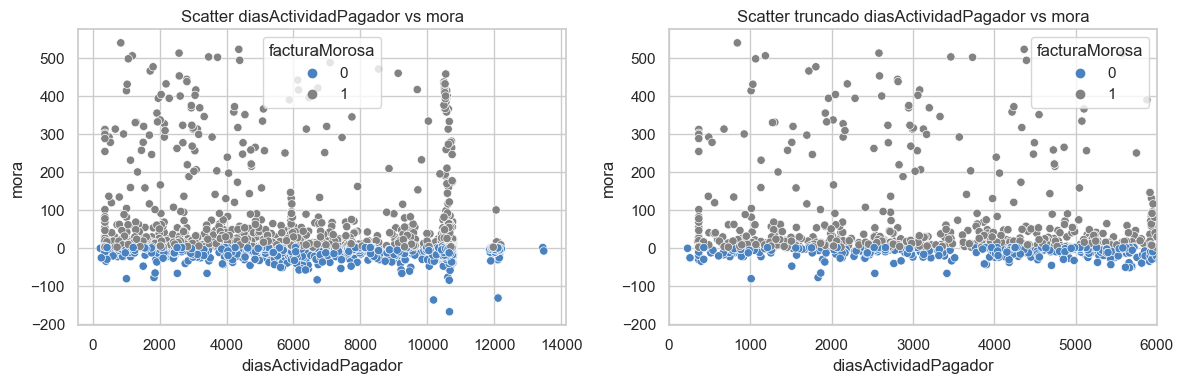

In [29]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot 1
sns.scatterplot(
    x="diasActividadPagador",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
axes[0].set_title("Scatter diasActividadPagador vs mora")

# Scatter plot 2
sns.scatterplot(
    x="diasActividadPagador",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Scatter truncado diasActividadPagador vs mora")

# Ajustamos el diseño
axes[1].set_xlim([0, 6000])
plt.tight_layout()

# Mostramos los scatter plots
plt.show()

##### Relación con la variable factMorosa

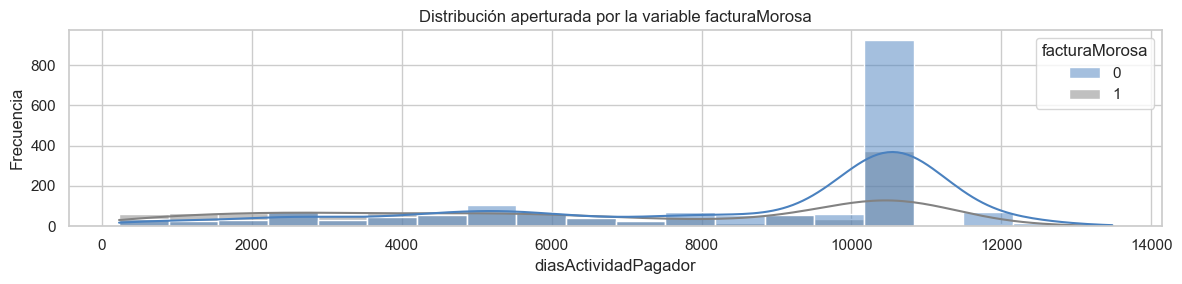

In [30]:
# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear el histograma
plt.figure(figsize=(12, 3))

sns.histplot(
    df,
    x="diasActividadPagador",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregar etiquetas y título
plt.xlabel("diasActividadPagador")
plt.ylabel("Frecuencia")
plt.title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostrar el histograma
plt.show()

**Notas:**
A nivel de relevancia para el modelo no podríamos mencionar nada destacable. Pero si llama la atención la frecuencia alta pasando los 10.000 días de actividades. Esto puede ser que hay muchos pagadores con mucha antiguedad o que puede ser que los pagadores mas antiguos tengan muchas facturas.

#### Clients 12 Months

##### Boxplot
La idea es detectar outliers dado que ya observamos anteriormente las estadística descriptiva de cada variable.

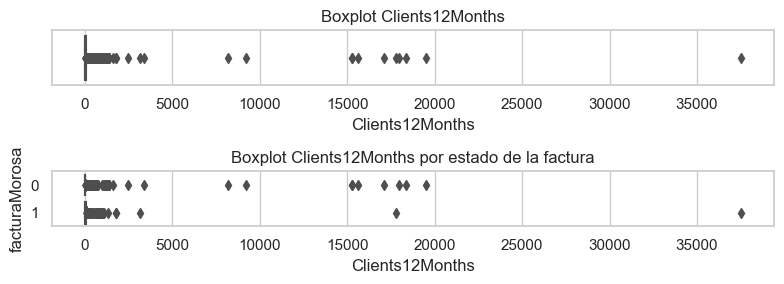

In [31]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 3), sharex=False)

# Boxplot 1
sns.boxplot(x="Clients12Months", data=df, color="#4A81BF", ax=axes[0])
axes[0].set_title("Boxplot Clients12Months")

# Boxplot 2
sns.boxplot(
    y="facturaMorosa",
    x="Clients12Months",
    data=df,
    orient="h",
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Boxplot Clients12Months por estado de la factura")

# Ajustamos el diseño
plt.tight_layout()

# Mostramos los boxplots
plt.show()

**Notas:**
Si bien existen valores extremos pueden darse el caso que existan algunas empresas como por ejemplo ecommerce, que manejan miles de clientes al años.

##### Relación con la variable mora

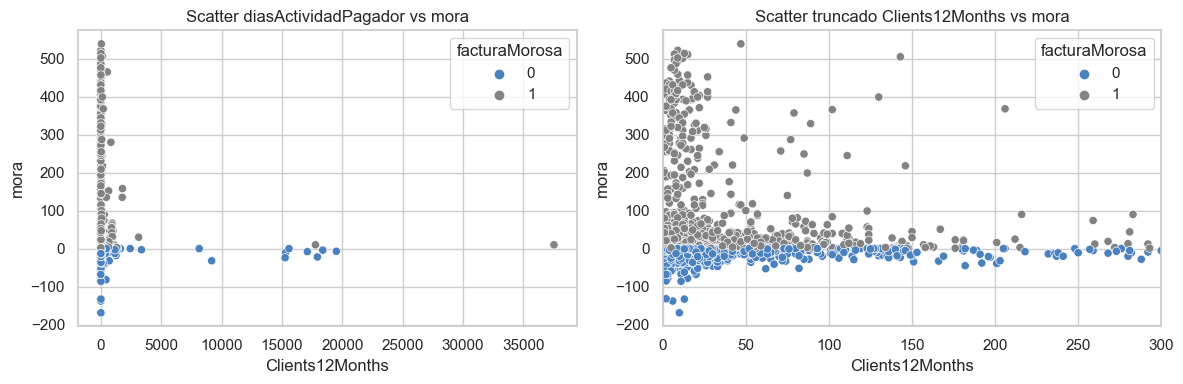

In [32]:
# Configuramos el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Creamos la figura y los ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# Scatter plot 1
sns.scatterplot(
    x="Clients12Months",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[0],
)
axes[0].set_title("Scatter diasActividadPagador vs mora")

# Scatter plot 2
sns.scatterplot(
    x="Clients12Months",
    y="mora",
    hue="facturaMorosa",
    data=df,
    palette=["#4A81BF", "#828282"],
    ax=axes[1],
)
axes[1].set_title("Scatter truncado Clients12Months vs mora")

# Ajustamos el diseño
axes[1].set_xlim([0, 300])
plt.tight_layout()

# Mostramos los scatter plots
plt.show()

##### Relación con la variable factMorosa

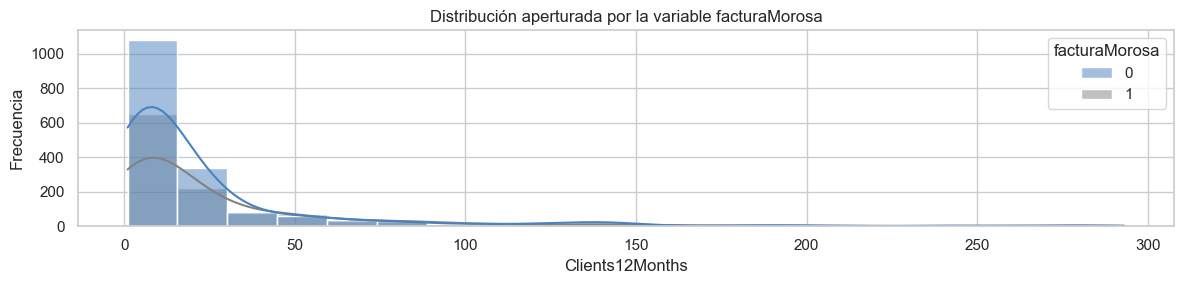

In [33]:
# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear el histograma
plt.figure(figsize=(12, 3))

sns.histplot(
    df.loc[df["Clients12Months"] < 300],
    x="Clients12Months",
    hue="facturaMorosa",
    bins=20,
    palette=["#4A81BF", "#828282"],
    kde=True,
)

# Agregar etiquetas y título
plt.xlabel("Clients12Months")
plt.ylabel("Frecuencia")
plt.title("Distribución aperturada por la variable facturaMorosa")

# Ajustamos el diseño
plt.tight_layout()

# Mostrar el histograma
plt.show()

**Notas:**
Se podía presumir inicialmente que empresas con mayor cantidad de clientes por una carga administrativa podía tener una mayor cantidad de facturas morosas, pero eso no pudo verse al momento en el análisis realizado.

### Outliers

#### Detección de outliers

In [34]:
# Creamos una funcion que detecte outliers utilizando dos metodos diferentes


def columnas_con_valores_atipicos(
    dataframe, metodo="zscore", umbral_zscore=3, umbral_iqr=1.5
):
    """
    Identifica las columnas en un DataFrame que contienen valores atípicos.

    Parámetros:
    - dataframe (pd.DataFrame): DataFrame que se va a analizar.
    - metodo (str): Método para la detección de valores atípicos. Puede ser 'zscore' o 'iqr'.
    - umbral_zscore (float): Umbral Z-Score para el método 'zscore'. Valores fuera de este umbral se consideran atípicos.
    - umbral_iqr (float): Umbral para el método del Rango Intercuartílico (IQR). Valores fuera de este umbral se consideran atípicos.

    Devuelve:
    - columnas_con_atipicos (list): Lista de nombres de columnas que contienen valores atípicos según el método seleccionado.
    """
    columnas_con_atipicos = []

    for columna in dataframe.columns:
        if metodo == "zscore":
            scores = zscore(dataframe[columna])
            outliers = dataframe[abs(scores) > umbral_zscore]
        elif metodo == "iqr":
            q1 = dataframe[columna].quantile(0.25)
            q3 = dataframe[columna].quantile(0.75)
            iqr = q3 - q1
            outliers = dataframe[
                (dataframe[columna] < q1 - umbral_iqr * iqr)
                | (dataframe[columna] > q3 + umbral_iqr * iqr)
            ]
        else:
            raise ValueError("Método no válido. Use 'zscore' o 'iqr'.")

        if not outliers.empty:
            columnas_con_atipicos.append(columna)

    return columnas_con_atipicos

In [35]:
# Método Z-Score
columnas_atipicas_zscore = columnas_con_valores_atipicos(df, metodo="zscore")
print("Columnas con valores atípicos (Z-Score):", columnas_atipicas_zscore)

Columnas con valores atípicos (Z-Score): ['montoFactura', 'relationDays', 'relationRecurrence', 'issuerInvoicesAmount', 'issuerCancelledInvoices', 'Clients12Months', 'mora']


In [36]:
# Método IQR
columnas_atipicas_iqr = columnas_con_valores_atipicos(df, metodo="iqr")
print("Columnas con valores atípicos (IQR):", columnas_atipicas_iqr)

Columnas con valores atípicos (IQR): ['montoFactura', 'relationDays', 'relationRecurrence', 'issuerInvoicesAmount', 'issuerCancelledInvoices', 'Clients12Months', 'mora']


**Notas:**
Básicamente la mayoría de las variables tienen outliers. Vamos a clasificar estas en dos grupos: en las que dichos valores pueden darse a cirscunstancia normales del negocio de las que no. Subjetivamente los dos grupos quedarían de la siguiente forma:

- Variables a tratar: montoFactura, issuerInvoicesAmount y Clients12Months.
- Variables consideradas con valores válidos dado el negocio: el resto.


#### Procesamiento de outliers
Mencionamos en el notebook anterior que dada la poca cantidad de registros no es conveniente descartarlo del análisis. Actualmente existen modelos robustos ante estos. De todas formas para probar algunas alternativas haremos dos tipos de transformaciones.

- Wisorizing: truncamos los grandes valores imputandole el percentil 95.

In [37]:
# Mantenemos las variables anteriores y creamos nuevas variables
df["montoFacturaWsz"] = df["montoFactura"].copy()
df["issuerInvoicesAmountWsz"] = df["issuerInvoicesAmount"].copy()
df["Clients12MonthsWsz"] = df["Clients12Months"].copy()

In [38]:
# Aplicamos wisorizing
df.loc[
    df["montoFacturaWsz"] > df["montoFacturaWsz"].quantile(0.95), "montoFacturaWsz"
] = df["montoFacturaWsz"].quantile(0.95)
df.loc[
    df["issuerInvoicesAmountWsz"] > df["issuerInvoicesAmountWsz"].quantile(0.95),
    "issuerInvoicesAmountWsz",
] = df["issuerInvoicesAmountWsz"].quantile(0.95)
df.loc[
    df["Clients12MonthsWsz"] > df["Clients12MonthsWsz"].quantile(0.95),
    "Clients12MonthsWsz",
] = df["Clients12MonthsWsz"].quantile(0.95)

### Guardado de datos

In [39]:
df.to_csv("../data/intermediate/dataset_outliers_processed.csv", index_label=False)